In [1]:
import sys, os
sys.path.append(os.environ['rapp'])
sys.path.append(os.environ['raco'])
sys.path.append(os.environ['rapl'] + '/azav')

import numpy as np
import scipy as sp
import pickle

import matplotlib.pyplot as plt

%matplotlib inline

from azav_util import *
from plotcommon import *
from common import *

In [2]:
# Get Rachel's solar data
di = get_dict('gongdata/avgong1995-2009rls_full.pkl')
di.keys()

dict_keys(['om', 'om_err', 'nt', 'nr', 'tt', 'rr', 'sint', 'cost', 'rr_2d', 'tt_2d', 'sint_2d', 'cost_2d', 'xx', 'zz'])

In [3]:
# cut the data off below 0.5*rsun (like in Rachel's plot)
rbot = 0.5*rsun

In [4]:
# diffrot in "lab" frame
Om_nhz = di['om']
Om_err_nhz = di['om_err']

Om = Om_nhz*1e-9*(2*np.pi) # nHz --> rad/s

nt = di['nt']
nr = di['nr']

tt = di['tt']
rr = di['rr']*rsun

cost = di['cost']
sint = di['sint']

cost_2d = di['cost_2d']
sint_2d = di['sint_2d']

rr_2d = di['rr_2d']*rsun

xx = di['xx']
zz = di['zz']

In [5]:
# get rotation rate derivatives
dOmdr = np.gradient(Om, rr, axis=1)
dOmdt = np.gradient(Om, tt, axis=0)/rr_2d
dOmdz = cost_2d*dOmdr - sint_2d*dOmdt
dOmdl = sint_2d*dOmdr + cost_2d*dOmdt

/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


In [6]:
# read in model S and interpolate onto radial grid
fname = os.environ['notes'] + '/Model_S/Model_S.pkl'
model_S = get_dict(fname)
model_S.keys()

dict_keys(['msun', 'rsun', 'lsun', 'zsun', 'x0sun', 'alphasun', 'agesun', 'rr', 'lnq', 'grav', 'tmp', 'prs', 'rho', 'xfrac', 'lum', 'opa', 'eps', 'gamma', 'gamma_ad', 'delta', 'c_p', 'mue', 'ne', 'dsdr', 'nsq', 'zfrac', 'nu', 'kappa', 'eta', 'prm', 'pr', 'drhodr', 'dtmpdr', 'dprsdr', 'dlnrho', 'dlntmp', 'dlnprs', 'gas_constant', 'ircut', 'rcut', 'irbcz', 'rbcz', 'frad', 'heat', 'rtach', 'dtach', 'irtach', 'irtach1', 'irtach2', 'rtach1', 'rtach2'])

In [7]:
rr_model_S = model_S['rr']

y = model_S['grav']
f = sp.interpolate.interp1d(rr_model_S, y)
grav = f(rr)

y = model_S['c_p']
f = sp.interpolate.interp1d(rr_model_S, y)
c_p = f(rr)

y = model_S['tmp']
f = sp.interpolate.interp1d(rr_model_S, y)
tmp = f(rr)

In [8]:
# compute the thermal wind
rhs = (1./grav).reshape((1, nr)) * rr_2d**2*sint_2d * (2*Om*dOmdz)

def integrate_from_equator(arr):
    int_arr = np.zeros((nt, nr))
    for it in range(nt):
        int_arr[it, :] = np.trapz(arr[:it+1, :], tt[:it+1], axis=0)
    return int_arr

s_dev_nd = integrate_from_equator(rhs)

Text(0.5, 1.0, 'S_dev/c_p')

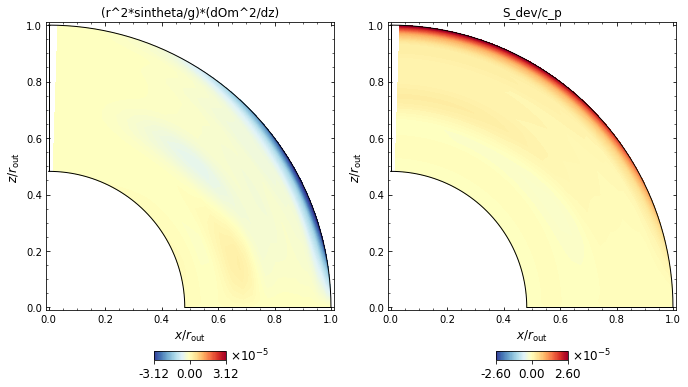

In [9]:
# plot DR derivatives, x r sin theta

# specify any particular "command line arguments" here
notebook_clas = dict({'halfplane': True, 'sub_width_inches': 4, 'ncontours': 20,
                     'nplots': 2, 'plotcontours': False})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)

plot_azav (rhs, rr, cost, fig, axs[0,0], **kw_plot_azav)
#kw_plot_azav.minmax = -1e-5, 1e-5
plot_azav (s_dev_nd, rr, cost, fig, axs[0, 1], **kw_plot_azav)

axs[0,0].set_title('(r^2*sintheta/g)*(dOm^2/dz)')
axs[0,1].set_title('S_dev/c_p')

Text(0.5, 1.0, 'Solar thermal-wind temp. (K)')

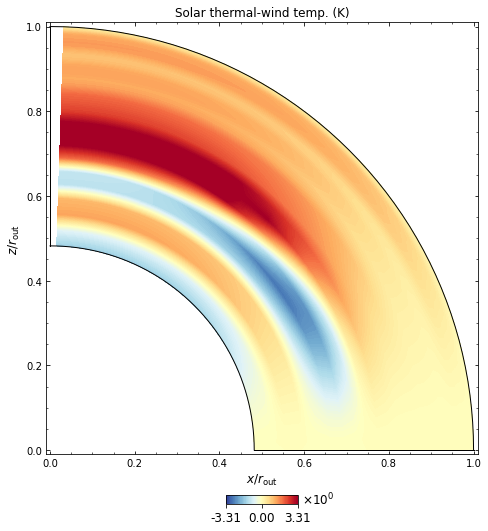

In [10]:
# compute and plot the temperature deviation (in units)
t_dev = s_dev_nd * tmp.reshape((1, nr))
notebook_clas = dict({'halfplane': True, 'sub_width_inches': 6, 'ncontours': 20, 'plotcontours': False})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)
ax = axs[0, 0]

plot_azav (t_dev, rr, cost, fig, ax, **kw_plot_azav)

ax.set_title("Solar thermal-wind temp. (K)")

In [11]:
# there's nans here at the highest latitude
s_dev_nd

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.46926663e-08,  6.37633718e-08,  6.26714840e-08, ...,
         1.64798748e-09, -1.03201965e-09, -1.88744031e-09],
       [ 2.93879952e-07,  2.90244650e-07,  2.86075572e-07, ...,
         5.80046674e-09, -4.54607508e-09, -7.67285360e-09],
       ...,
       [ 2.60882320e-05,  2.58703447e-05,  2.56077533e-05, ...,
         4.05267325e-07, -1.62477686e-07, -3.66154381e-07],
       [ 2.60885922e-05,  2.58707017e-05,  2.56081067e-05, ...,
         4.05271659e-07, -1.62474920e-07, -3.66153248e-07],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])

In [12]:
# s_dev with latitudinal mean subtracted---compare to Vasil

s_dev_nd_latav = np.trapz((s_dev_nd*sint_2d)[:nt-1, :], tt[:nt-1], axis=0)
s_dev_nd_latav

array([-1.39253736e-05, -1.38071341e-05, -1.36633476e-05, -1.36745718e-05,
       -1.36969743e-05, -1.36529371e-05, -1.35583216e-05, -1.33232847e-05,
       -1.28760475e-05, -1.21607365e-05, -1.12510395e-05, -1.03605748e-05,
       -9.51529434e-06, -8.30887001e-06, -6.66831005e-06, -5.22282588e-06,
       -4.24405579e-06, -3.26128653e-06, -2.13622310e-06, -1.35378732e-06,
       -1.13608434e-06, -1.15019496e-06, -9.98507808e-07, -7.77873164e-07,
       -8.09309961e-07, -9.33026123e-07, -8.87955905e-07, -8.78531348e-07,
       -1.09224902e-06, -1.03731072e-06, -4.10625652e-07,  2.99181836e-07,
        5.96707108e-07,  3.14370143e-07, -1.95296939e-07, -2.08835476e-07,
        1.13121516e-07,  2.21345032e-07])

Text(0.5, 1.0, 'S/c_p (mean subtracted)')

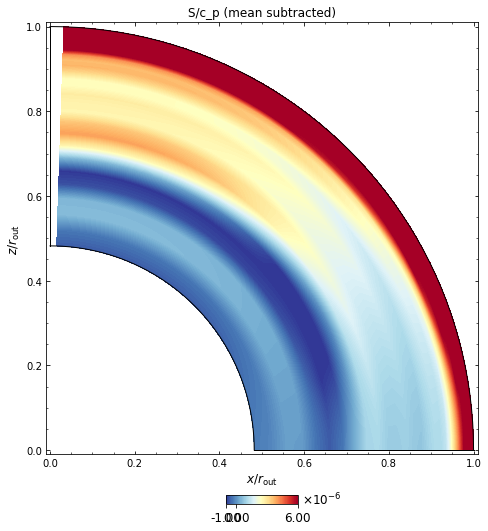

In [13]:
# plot s_dev with latitudinal mean subtracted---compare to Vasil

notebook_clas = dict({'halfplane': True, 'sub_width_inches': 6, 'ncontours': 20, 'plotcontours': False})

# change some defaults
azav_fig_dimensions['sub_aspect'] = 1.0

azav_fig_dimensions['margin_top_inches'] += 0.25
plot_azav_kwargs_default['plotlatlines'] = False

# plot_azav and make_figure kwargs default
make_figure_kwargs_default.update(azav_fig_dimensions)

# update keyword args with "notebook" CLAs
kw_plot_azav = update_dict(plot_azav_kwargs_default, notebook_clas)
kw_make_figure = update_dict(make_figure_kwargs_default, notebook_clas)

# make figure and plot
fig, axs, fpar = make_figure(**kw_make_figure)
ax = axs[0, 0]

kw_plot_azav['minmax'] = -1e-6, 6e-6
plot_azav (s_dev_nd - s_dev_nd_latav.reshape((1, nr)), rr, cost, fig, ax, **kw_plot_azav)

ax.set_title("S/c_p (mean subtracted)")

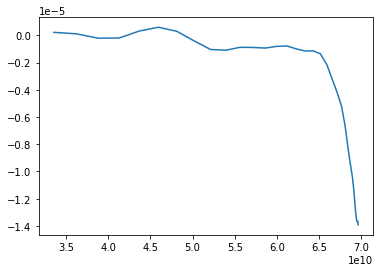

In [14]:
plt.plot(rr, s_dev_nd_latav)